# Math 425 Computation Linear Algebra
## Final Project, Problem 2.
##### *Topics in Matrix Transformation, Least-squares, Linear Modelling and Singular Vaule Decomposition.

### Group 3

+ Anneke Moeller; code review, validation and research
+ Shem Cheng; github repo testing, planning and scheduling
+ Rai’d Muhammad; code review and user validation
+ Brent Thorne; software, merging and reporting

### ToDo

+ add QR analysis and compare to least-squares
+ ask about receiver operating characteristic (ROC) curves, (historically based in WWII radar)
+ determining an “ideal” cut-off value with trade-off between sensitivity (true positives) and specificity (true negatives)

### References 
+ https://acutecaretesting.org/en/articles/roc-curves-what-are-they-and-how-are-they-used
+ https://wentzwu.com/2019/05/05/which-is-more-important-accuracy-or-acceptability/
+ https://isle.hanover.edu/Ch02Methods/Ch02SDT_ROC.html
+ http://wixtedlab.ucsd.edu/publications/wixted2019/The_Forgotten_History_of_Signal_Detection_Theory.pdf
+ https://en.wikipedia.org/wiki/Receiver_operating_characteristic

### Problem 2. Analyse patient data for cell nuclei features. 

##### The goal is to decide whether the cells are malignant or benign.

In [1]:
# environment setup, try to make it clear which library I'm using for what
import numpy as np  # nice arrays and other stuff
import sympy as sym # symbollic maths 
from sympy.matrices import Matrix # pretty matrices
from sympy import Eq # pretty equations
from sympy.physics.quantum.dagger import Dagger # we'll want this later...
from math import e, pi, sqrt # Mathy math math
from mpl_toolkits.mplot3d import Axes3D # we like 3d quivers for tutorials
import matplotlib.pyplot as plt # old standby for plotting like a villian
from IPython.display import display, Math, Latex # used to display formatted results in the console
sym.init_printing()  # initialize pretty printing
import time
import csv

#### The procedure below takes a single argument, a string giving the pathname of a file. It reads the data in the specified file and returns a pair (A, b, D) where:

 A is a matrix whose rows correspond to the data for each patient in the data set. The elements in a row correspond to the 30 features measured for a patient.

 b is a vector whose domain is the set of patients and $b[r]$ is 1 if the specimen of patient $r$ is malignant and it’s -1 if the specimen is benign.

 D is the feature parameter map. (extended for demostaton purposes)
 
# Warning: This code may cause brain cancer.
##### FIXME!!! Rewrite this in a more straight forward manner. Why Klein, why?  Sad kittens...

In [2]:
# Copyright 2013 Philip N. Klein
from vec import Vec  # This library is rather pointless after Ch2.
from vecutil import vec2list # I'll give it to Klein, he definately inspires the student to find a better way.
from sympy import Matrix

def read_training_data(fname, D=None):
    """Given a file in appropriate format, and given a set D of features,
    returns the pair (A, b) consisting of
    a P-by-D matrix A and a P-vector b,
    where P is a set of patient identification integers (IDs).

    For each patient ID p,
      - row p of A is the D-vector describing patient p's tissue sample,
      - entry p of b is +1 if patient p's tissue is malignant, and -1 if it is benign.

    The set D of features must be a subset of the features in the data (see text).
    """
    file = open(fname)
    params = ["radius", "texture", "perimeter","area","smoothness","compactness","concavity","concavePoints","symmetry","fractalDimension"];
    stats = ["(mean)", "(stderr)", "(worst)"]
    feature_labels = set([y+x for x in stats for y in params]) 
    feature_map = {params[i]+stats[j]:j*len(params)+i for i in range(len(params)) for j in range(len(stats))} # Brain cancer.
    if D is None: D = feature_labels
    feature_vectors = {}
    #patient_diagnoses = {}
    A = []
    b = []
    for line in file:
        row = line.split(",")
        patient_ID = int(row[0])  # parse out ID
        b.append(-1) if row[1] == 'B' else b.append(1) # parse malignant symbol and pack into b-Matrix
        feature_vectors[patient_ID] = Vec(D, {f:float(row[feature_map[f]+2]) for f in D}) # parse features as float
        A.append(vec2list(feature_vectors[patient_ID])) # pack feature vector into A-Matrix
    return Matrix(A), Matrix(b), feature_map 

In [3]:
def my_read_data(fname):
    """
    (attempts to) reimpliemnt read_training_data() in a pythonic way
    """
    mylist = []
    with open(fname) as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
                mylist.append(row) # might be better to parse array into matrix here
    data = np.array(mylist)
    result = data[:,1]
    b = Matrix([1 if r == 'M' else -1 for r in result])
    A = Matrix(data[:,2:])  # rather slow

    # add labels for our domain
    params = ["radius", "texture", "perimeter","area","smoothness","compactness","concavity","concavePoints","symmetry","fractalDimension"];
    stats = ["(mean)", "(stderr)", "(worst)"]
    labels = []
    for p in params:
        for s in stats:
            labels.append(p+s)
    D = Matrix(sym.symbols(labels))
    return A,b,D

In [4]:
# Report Stats
# see also: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
def stats(A,b,b_hat_sign):
    """
    Report on receiver operating characteristic (ROC)
    """
    s=b+b_hat_sign
    ii = [ i for i in range(len(s)) if s[i] == 0]
    # AUC and ROC values
    FP = 0;    FN = 0
    for i in ii: 
        if b[i] > 0:
            FN += 1;
        else:
            FP += 1;

    TP =0;    TN = 0
    for v in b:
        if v > 0:
            TP += 1
        else:
            TN += 1
    print(f'False Positive/Negative: {len(ii)} out of {A.shape[0]}')
    print(f'TPR/Recall/Sensitivity = {TP/(TP+FN)}')
    print(f'Specificity = {TN/(TN+FP)}')
    print(f'FPR = {FP/(TN+FP)}') # same as (1 - Specificity)
    print(f'Error = {len(ii)/len(b)}')  # this what the problem is after

In [5]:
# read in training and validation data
A,b,D = read_training_data('data/train.data')
Av,bv,Dv = read_training_data('data/validate.data')

In [6]:
# show example sample
A.row(0) # Patient 0's sample features
b.row(0) # Patient 0's results, +1 if malignant, and -1 if benign.
A.row(0), b.row(0)

### Use least-squares approach ($A^TAx = A^Tb$) to find $\hat{x}$.

This approach is considerably faster than QR-Decomp used below and yields the same results.

In [7]:
t0 = time.time()
ATA = A.T*A
ATb = A.T*b

# solve for x_hat, do semi-manually to show method
ATAu = ATA.row_join(ATb) # augment A^TA with A^Tb
x_hat = (ATAu.rref(pivots=False)).col(-1)
b_hat = A*x_hat
t1 = time.time()
tt = t1-t0

print(f'Least-Squares single cycle execution time: {tt}')

Least-Squares single cycle execution time: 5.678204298019409


### Use QR approach ($\hat{x}=R^{-1}Q^Tb$) to find $\hat{x}$.

QR decomposition is noteably slower (6x) than least-squares method used below.

In [8]:
t0 = time.time()
Q,R = A.QRdecomposition()
x_hat = R.inv() * Q.T * b
b_hat = A*x_hat
t1 = time.time()
tt = t1-t0

print(f'QR-Decomposition single cycle execution time: {tt}')

QR-Decomposition single cycle execution time: 42.37107253074646


### Apply $\hat{x}$ to training data and compare resulting $\hat{b}$ orignal training $b$.

In [9]:
sign = lambda x: np.sign(x) # lambdafy
b_hat_sign = b_hat.applyfunc(sign)

stats(A,b,b_hat_sign)

False Positive/Negative: 14 out of 300
TPR/Recall/Sensitivity = 0.9182389937106918
Specificity = 0.9935483870967742
FPR = 0.0064516129032258064
Error = 0.04666666666666667


### Apply $\hat{x}$ to validation data and compare resulting $\hat{b}$ with validation $b$.

In [10]:
bv_hat = Av*x_hat
bv_hat_sign = bv_hat.applyfunc(sign)

stats(Av,bv,bv_hat_sign)

False Positive/Negative: 8 out of 260
TPR/Recall/Sensitivity = 0.967741935483871
Specificity = 0.970873786407767
FPR = 0.02912621359223301
Error = 0.03076923076923077


### Appendix. Least-squares
Let $A$ be an $m$x$n$ matrix.  The following statements are logically equivalent:

a. The equation $Ax=b$ has a unique least-squares solution for each $b$ in $\mathbb{R^m}$.

b. The columns of $A$ are linearly independent.

c. The matrix $A^TA$ is invertible.
When these statement are ture, the least-squares solution $\hat{x}$ is given by

#### $\hat{x}=(A^TA)^{-1}A^Tb$

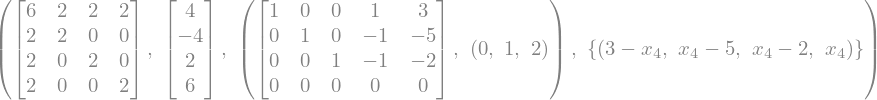

In [11]:
# Example 6.5.2, Lay, Find least-sqaures solution
A = Matrix([[1,1,0,0],\
           [1,1,0,0],\
           [1,0,1,0],\
           [1,0,1,0],\
           [1,0,0,1],\
           [1,0,0,1]])
b = Matrix([-3,-1,0,2,5,1])
x = sym.symbols('x1 x2 x3 x4')

A.T*A, A.T*b, (A.T*A).row_join(A.T*b).rref(), sym.linsolve((A.T*A, A.T*b), x)

### Appendix. QR Factorization
Given $m$x$n$ matrix $A$ with linearly independent columns, let $A=QR$ be a factorization of $A$.  Then, for each $b$ in $\mathbb{R^m}$, the equation Ax=b had unique least-squares solution given by 
##### $\hat{x}=R^{-1}Q^Tb$ (1)

note: Since $R$ above is upper triangular, $\hat{x}$ should be calculated as the exact solution of the equation
##### $Rx=Q^Tb$ (2)
It is much faster to solve (2) by back-substition or row operations than to compute $R^{-1}$ and use (1).

see also, Theorem 6.5.15, Lay

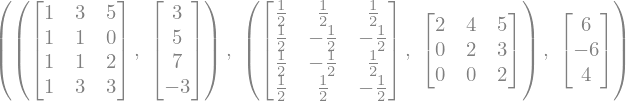

In [12]:
# Example 6.5.5, Lay, Find the least-squares solution
A = Matrix([[1,3,5],[1,1,0],[1,1,2],[1,3,3]])
b = Matrix([3,5,7,-3])
Q,R = A.QRdecomposition()
(A,b), (Q,R), (Q.T*b)